# Cell Image Classification 🧬

<img src="cancer-normal-cell-image.png" width=500 alt="The morphplogical difference between breast cancer cells and normal cancer cells.">

## ML Project Overview

In this project, I have applied some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where I am approached by a client to solve a problem.  

The main aims of this project are: 

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise data and determine the best pre-processing;
- to create the necessary datasets for training and testing purposes;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This project relates to the following 💻 ACS CBOK areas: 
- abstraction,
- design,
- hardware and software,
- data and information,
- HCI and programming.

🌸*By Oveena Widyaratne*

## Hypothetical Scenario:

💼 A client approaches to solve a machine learning problem for them. 

⚕️They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. The dataset contains measurements of several features that describe characteristics of cell nuclei present in digital images of breast tissue samples. These features include the mean, standard error, and "worst" (i.e., largest) values of measurements such as radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, and fractal dimension. Each feature is represented by a numeric value, and each data point represents a sample from either a malignant (cancerous) or benign (non-cancerous) breast tissue.

👩‍⚕️The client want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked us to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled **300 samples** for you, which is all they have at the moment.

In [131]:
# This code imports some libraries needed. 

# Common imports
import sys
import numpy as np
import time
import pandas as pd
import sklearn
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import re

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

### Step 01
Load the dataset from the csv file, `winconsin-dataset.csv`. Extract the feature names for use later on. The first column is our target and it contains the labels (benign and malignant). Note that we will be treating the _malignant_ case as our _positive_ case, as this is the **standard convention in medicine**.

In [17]:
data = pd.read_csv("winconsin-dataset.csv")

feature_names = data.columns[1:]

# variable that contains the answer from this step is the one assigned to step1_1data
step1_data = feature_names

### Step 02
As this data is well curated we do not need to worry about outliers, missing values or imputation in this case, but be aware that this is the exception, not the rule.

To familiarise with the nature and information contained in the data, we then display histograms for the data:
 - Isolate each group of features (mean, standard error, and worst) into its own DataFrame.
 - Display histograms for each feature in the _mean_ group.
 - On _each_ histogram the two classes displayed together in one plot **repeat this** for the _standard error_ and _worst_ groups; 

**Based on the histograms and using the function *corr()* or *numpy corrcoef()* which do you think are the 3 strongest features for discriminating between the classes?**

In [20]:
# Convert labels to 0 (benign) and 1 (malignant)
data['label'] = data['label'].map({'benign': 0, 'malignant': 1})

# Separate the mean, standard error, and worst groups into separate dataframes
mean_group = data.iloc[:, 1:11]
error_group = data.iloc[:, 11:21]
worst_group = data.iloc[:, 21:]

class_labels = ['benign', 'malignant'] 

# Plotting the histograms with both classes displayed together for each of the features
def plot_histograms(data_group, class_labels):
    fig = plt.figure(figsize=(12, 8)) 
    for i, feature in enumerate(data_group.columns):  
        plt.subplot(3, 4, i+1)  
        plt.hist([data_group[feature][data['label'] == 0], data_group[feature][data['label'] == 1]], label=class_labels)  
        plt.xlabel("Feature Value")  
        plt.ylabel("Frequency")  
        plt.legend() 
        plt.title(feature)
    plt.tight_layout()
    plt.show() 

# plot_histograms(mean_group, class_labels)
# plot_histograms(error_group, class_labels)
# plot_histograms(worst_group, class_labels)

# Calculate the correlation of each feature with the label
corr = data.corr()
feature_corr = corr['label'].drop('label')

# Get the top 3 features with the highest correlation
ranked_features = feature_corr.abs().sort_values(ascending=False).head(3).index.tolist()
print("Top 3 strongest features: ", ranked_features)

# The following code is used by the autograder
step2_data = ranked_features

Top 3 strongest features:  ['worst concave points', 'worst perimeter', 'worst radius']


## Step 03 

Converting the labels into 0s and 1s so that benign is represented by 0 and malignant is represented by 1.

Spliting the dataset into appropriate subsets for training, validation and test sets.

In [25]:
from sklearn.model_selection import train_test_split

# Split dataset into features and target variable
X = data.iloc[:, 1:]
y = data['label']

# Split dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42, stratify=y_train)

# Print the size of each resulting subset
print("Training set size: ", len(X_train))
print("Validation set size: ", len(X_val))
print("Test set size: ", len(X_test))

Training set size:  240
Validation set size:  30
Test set size:  30


### Step 04
Baseline measurements
For our classification task we will consider three simple baseline cases:
1. predicting all samples to be negative (class 1)
2. predicting all samples to be positive (class 2)
3. making a random prediction for each sample with equal probability for each class

In [32]:
# create arrays to hold the predicted labels for each baseline case
baseline1_preds = np.zeros(len(data), dtype=int)
baseline2_preds = np.ones(len(data), dtype=int)
baseline3_preds = np.random.choice([0, 1], size=len(data))

### Step 05

Writing a function that returns the following metrics for all baseline measures created in Step 04, use the function and print the metrics:

 - recall
 - precision
 - auc
 - f1score

In [37]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score

def calculate_metrics(y_true, y_pred):
    # Convert probabilities to class predictions using 0.5 as the threshold
    y_pred = np.array(y_pred).flatten()
    y_pred_class = (y_pred > 0.5).astype(int)
    # Calculate metrics
    rec = recall_score(y_true, y_pred_class)
    prec = precision_score(y_true, y_pred_class)
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred_class)
    return rec, prec, auc, f1

b1_metrics = calculate_metrics(data['label'], baseline1_preds)
b2_metrics = calculate_metrics(data['label'], baseline2_preds)
b3_metrics = calculate_metrics(data['label'], baseline3_preds)

for i, metrics in enumerate([b1_metrics, b2_metrics, b3_metrics]):
    print("Baseline", i+1)
    print("Recall: ", metrics[0])
    print("Precision: ", metrics[1])
    print("AUC: ", metrics[2])
    print("F1: ", metrics[3])
    print()

# The following code is used by the autograder.
step5_data = calculate_metrics

Baseline 1
Recall:  0.0
Precision:  0.0
AUC:  0.5
F1:  0.0

Baseline 2
Recall:  1.0
Precision:  0.4866666666666667
AUC:  0.5
F1:  0.6547085201793722

Baseline 3
Recall:  0.5342465753424658
Precision:  0.484472049689441
AUC:  0.4976427681907134
F1:  0.50814332247557



C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 ### Step 06

Next, we create a function which takes in the true labels and the predictions and returns the following parameters:

* Number of True Positives (TP)
* Number of True Negatives (TN)
* Number of False Positive (FP)
* Number of False Negative (FN)

In [43]:
# This function returns the number of TP, TN, FP, FN.
def get_values(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn

### Step 07 
Based on the above baseline tests and the client's requirements, we **choose a performance metric** to use for evaluating/driving our machine learning methods:
* For AUC - "roc_auc"
* For recall - "recall"
* For precision - "precision"
* For F1 Score - "f1"

***NOTE:*** Not all the metrics are equally useful for meeting the requirements of the client, thereby, choose only the one most suitable metric.

In [46]:
# Choose the best metric of the five and assign to the variable below. The variable takes a string.
chosen_metric = 'roc_auc'

### Step 08
**Creating a SGD baseline**

For a stronger baseline, I will be **training the Stochastic Gradient Descent classifier (SGD) model** on the training data and evaluate it on the validation data. 
I will use a Pipeline for this which considers the preprocessing and the SGD model. For this baseline case I will use the default settings for all the hyperparameters.

In [49]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier

# Create pre-processing pipeline
preproc_pl = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create SGD model pipeline which has preproc_pl as the pre-processing part
sgd_base = Pipeline([
    ('preprocessing', preproc_pl),
    ('sgd', SGDClassifier(random_state=42))
])

# fit the SGD pipeline on the training data
sgd_base.fit(X_train, y_train)

# evaluate on the validation data
y_val_preds = sgd_base.predict(X_val)

# Calculate metrics
sgd_val_metrics = calculate_metrics(y_val, y_val_preds)

### Step 09

On the validation data, we calculate and print or display the **normalised** version of the confusion matrix.  Given the normalised confusion matrix, **what is the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer?  Which of the client's two criteria does this relate to, and is this baseline satisfying this criterion or not?**

In [55]:
# Confusion matrix here
cmat = confusion_matrix(y_val, y_val_preds, normalize='true')

# Display or print cmat
print(cmat)

# Assign the required probability to the variable below
required_prob = cmat[1, 0]
# Choose which of the client's two criteria does this relate to (1 or 2)
criteria = 1
# Does the baseline model satisfy this criterion? ("YES" or "NO")
satisfy = "YES" if required_prob <= 0.05 else "NO"
print("Satisfy:", satisfy)

[[1.         0.        ]
 [0.06666667 0.93333333]]
Satisfy: NO


#### Main classifier 

In this part, I need to try different models for classification, check their performance and determine the best for the present scenario.

We want to strike a balance between computation time and performance using **GridSearchCV** to try and display the performance of the different classifiers and the optimised hyperparameters.

### Step 10

**Train and optimise the hyperparameters** to give the best performance for a **KNN (K-Nearest Neighbour)** classifier. For this model we consider and  evaluate the following parameters:

* n_neighbors (with no value greater than 20)
* weights
* algorithm
* metric
* p (with no value greater than 20)

I have read the documentation about this model to find some proper ranges and ensure that I use the pipeline created in **Step 08** to train this model. **How to decide what are the best setting of parameters? -> use the best metric identified in the Step 07**.

In [63]:
# Write your solution here
from sklearn.neighbors import KNeighborsClassifier

# Put the pipeline with the appropriate model 
knn_pl = Pipeline([
    ('preprocessing', preproc_pl),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid for KNN
param_grid_knn = {
    'knn__n_neighbors': [1, 5, 8, 15, 20],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'knn__p': [1, 5, 10, 15, 20]
}

# Use GridSearchCV here with cv=5
knn_model = GridSearchCV(knn_pl, param_grid=param_grid_knn, cv=5, scoring=chosen_metric, verbose=1, return_train_score=True)

# Fit the model to the training data
knn_model.fit(X_train, y_train)

# Return best parameters in a dictionary
knn_best_parameters = knn_model.best_params_
print("Best parameters for KNN:", knn_best_parameters)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best parameters for KNN: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform'}


### Step 11
**Train and optimise the hyperparameters** to give the best performance for a **Decision tree classifier** classifier. For this model consider and  evaluate the following parameters:

* criterion
* max_depth (with no value greater than 20)
* min_samples_split (with no value greater than 20)
* min_samples_leaf (with no value greater than 20)
* max_features

In [65]:
from sklearn.tree import DecisionTreeClassifier

# Put the pipeline with the appropriate model 
dt_pl = Pipeline([
    ('preprocessing', preproc_pl),
    ('dt', DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [1, 3, 5, 10, 15, 20],
    'dt__min_samples_split': [2, 5, 10, 15, 20], 
    'dt__min_samples_leaf': [1, 5, 11, 15, 20],
    'dt__max_features': ['sqrt', 'log2']
}

# Use GridSearchCV with cv=5
dt_model = GridSearchCV(dt_pl, param_grid=param_grid_dt, cv=5, scoring=chosen_metric, verbose=1, return_train_score=True)

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Return best parameters in a dictionary
dt_best_parameters = dt_model.best_params_
print("Best parameters for Decision Tree:", dt_best_parameters)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best parameters for Decision Tree: {'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__max_features': 'log2', 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 20}


### Step 12
Next steo is to **train and optimise the hyperparameters** to give the best performance for a **C-Support Vector Classification** classifier. For this model we can consider and evaluate the following parameters:

* C. Regularisation parameter (with no value greater than 100)
* kernel
* gamma

In [70]:
from sklearn.svm import SVC
# Put the pipeline with the appropriate model 
svc_pl = Pipeline([
    ('preprocessing', preproc_pl),
    ('svc', SVC(random_state=42))
])

# Defining the parameter grid for the Support Vector Classification
param_grid_svc = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__gamma': ['scale', 'auto']
}

# Use GridSearchCV with cv=5 
svc_model = svc_model = GridSearchCV(svc_pl, param_grid=param_grid_svc, cv=5, scoring=chosen_metric, verbose=1, return_train_score=True)

# Trying to fit my model into the training data set
svc_model.fit(X_train, y_train)

# Return best parameters in a dictionary
svc_best_parameters = svc_model.best_params_
print("Best parameters for SVC:", svc_best_parameters)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for SVC: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


### Step 13
We then try **train and optimise the hyperparameters** to give the best performance for a **SGD classifier** classifier. For this model consider and  evaluate the following parameters:
* loss 
* penalty
* alpha (with no value greater than 100)
* learning_rate
* eta0 (with no value greater than 100)


In [72]:
from sklearn.linear_model import SGDClassifier

# Put the pipeline with the appropriate model 
sgd_pl = Pipeline([
    ('preprocessing', preproc_pl),
    ('sgd', SGDClassifier(random_state=42))
])
# Define the parameter grid for the SGD Classifier
param_grid_sgd = {
    'sgd__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'sgd__penalty': ['l2', 'l1', 'elasticnet'],
    'sgd__alpha': [0.1, 1, 10, 100],
    'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'sgd__eta0': [0.01, 0.1, 1, 10, 100]
}

# Use GridSearchCV with cv=5
sgd_model = GridSearchCV(sgd_pl, param_grid=param_grid_sgd, cv=5, scoring=chosen_metric, verbose=1, return_train_score=True)

# Fit the model to the training data
sgd_model.fit(X_train, y_train)

# Return best parameters in a dictionary
sgd_best_parameters = sgd_model.best_params_
print("Best parameters for SGD:", sgd_best_parameters)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_mo

Best parameters for SGD: {'sgd__alpha': 0.1, 'sgd__eta0': 0.01, 'sgd__learning_rate': 'constant', 'sgd__loss': 'perceptron', 'sgd__penalty': 'l2'}


### Step 14

Considering the previous results using **GridSearchCV** for each one of the main classifiers, we then retrieve the obtained score using the best parameters in each case. Also indicating which are the three **best** models. 

In [75]:
# Assign the best score for each model 
knn_best_cv_scoring = knn_model.best_score_
dt_best_cv_scoring = dt_model.best_score_
svc_best_cv_scoring = svc_model.best_score_
sgd_best_cv_scoring = sgd_model.best_score_

# Map the model names to their scores
model_scores = {
    "knn": knn_best_cv_scoring,
    "dt": dt_best_cv_scoring,
    "svc": svc_best_cv_scoring,
    "sgd": sgd_best_cv_scoring
}

# Sort the scores in descending order
top_three_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)[:3]

'''
What are the three best models so far? Assign a list of the three best models
to the variable below (best to worst). The model options are "knn", "dt", "svc" or "sgd"
'''
best_models = [x[0] for x in top_three_models]
print("Best Models:", best_models)

Best Models: ['sgd', 'svc', 'knn']


### Step 15

Once I have performed the search of the best parameters for each one of these models, I can display the general performance of each model using the next function **plot_compare_classifier_score**. An example plot using the function provided would look like the following:

<center><img src="scoring_curves.jpg" width=900 alt="Example loss curve plot"></center>

In [ ]:
# Function to check the performance of each parameter.
def pooled_var(stds):
    # https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

# Function to create loss curves
def plot_gridSearchCV_loss_curve(cv_results,grid_params,title):

    df = pd.DataFrame(cv_results)
    results = ['mean_test_score',
               'mean_train_score',
               'std_test_score',
               'std_train_score']


    fig, axes = plt.subplots(1, len(grid_params),
                             figsize = (5*len(grid_params), 7),
                             sharey='row')
    axes[0].set_ylabel("Score", fontsize=25)


    for idx, (param_name, param_range) in enumerate(grid_params.items()):
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                  'mean_test_score': 'mean',
                  'std_train_score': pooled_var,
                  'std_test_score': pooled_var})

        previous_group = df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        lw = 2
        axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                        grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                        color="darkorange", lw=lw)
        axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        color="navy", lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle(f'{title} Validation curves', fontsize=30)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)
    plt.show()
    
# Check the performance for each model (knn, dt, svc and sgd). Use plot_gridSearchCV_loss_curve() function.

## Step 16

Having identified the best three models in Step 14, we train them using their best parameters on the training data, and then make predictions on the validation set. Finally, calculate and display the following metrics for each case:
* recall
* precision
* auc score
* f1 score

The hurdle is that none of the above metrics should be below 0.8. We will use the function created in Step 05 to obtain the above metrics for each model.

In [79]:
predictions_model1 = sgd_model.predict(X_val)
predictions_model2 = svc_model.predict(X_val)
precictions_model3 = knn_model.predict(X_val)

metrics_model1 = calculate_metrics(y_val, predictions_model1)
metrics_model2 = calculate_metrics(y_val, predictions_model2)
metrics_model3 = calculate_metrics(y_val, precictions_model3)

for i, model in enumerate([predictions_model1, predictions_model2, precictions_model3]):
    print(f"Model {i+1} Metrics")
    print("Recall: ", metrics_model1[0])
    print("Precision: ", metrics_model1[1])
    print("AUC: ", metrics_model1[2])
    print("F1: ", metrics_model1[3])
    print()

Model 1 Metrics
Recall:  0.8666666666666667
Precision:  1.0
AUC:  0.9333333333333333
F1:  0.9285714285714286

Model 2 Metrics
Recall:  0.8666666666666667
Precision:  1.0
AUC:  0.9333333333333333
F1:  0.9285714285714286

Model 3 Metrics
Recall:  0.8666666666666667
Precision:  1.0
AUC:  0.9333333333333333
F1:  0.9285714285714286



### Step 17

**Final performance**

Choose the best model of the top 3 obtained in **Step 14**. 
Calculate and display an unbiased performance measure that can be presented to the client.

In [82]:
'''
Assign the training features, training labels that you would use for this step to the variables
below.
'''
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.09, random_state=42, stratify=y)

# Assign the best model to the variable below and train it
final_model = sgd_model.best_estimator_
final_model.fit(X_train_final, y_train_final)

# Assign the predictions made from your chosen best model for the unbiased estimate to the variable below.
predictions_final_model = final_model.predict(X_test)

# Choose a performance metric based on the client's requirement and assign the result to the variable below.
chosen_performance_metric_result = roc_auc_score(y_test, predictions_final_model)
print("Chosen Performance Metric Result:", chosen_performance_metric_result)

Chosen Performance Metric Result: 0.9666666666666667


### Step 18

**Rank features**

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a *T-score* (often used in statistics, and in the **LDA** machine learning method) for each feature. The formula for the *T-score* is 

$$
  T_{score} =  \frac{(mean(x_{2}) - mean(x_{1}))}{0.5(stddev(x_{2}) + stddev(x_{1}))}
$$

where $x_{1}$ and $x_{2}$ are the datasets corresponding to the two classes. Large values for the *T-score* (either positive or negative) indicate discriminative ability. Define a function which returns this *T-score*. For this process use the entire dataset.

**Using the defined function, calculate the *T-score* for each feature and obtain the best 4 features according to this score.**

In [85]:
# Implement this function to calculate T score
def calculate_t_score(x1, x2):
    mean1, mean2 = np.mean(x1), np.mean(x2)
    std1, std2 = np.std(x1), np.std(x2)
    t_score = (mean2 - mean1) / (0.5 * (std1 + std2))
    return t_score

# Split the training data into two datasets corresponding to the two classes
X_train_benign = X_train_final[y_train_final == 0]
X_train_malignant = X_train_final[y_train_final == 1]

# Calculate the T score for the feature
t_scores = []
for feature in range(X_train_final.shape[1]):
    t_score = calculate_t_score(X_train_benign.iloc[:, feature], X_train_malignant.iloc[:, feature])
    t_scores.append(t_score)

# Assign the top 4 features (in order) to this variable. It should be a list containing 4 feature names (strings).
top4_idx = np.argsort(np.abs(t_scores))[::-1][:4]
best_four_features = feature_names[top4_idx].tolist()
print("Best Four Features:", best_four_features)

Best Four Features: ['worst concave points', 'worst perimeter', 'worst radius', 'mean concave points']


### Step 19

You can visualise the results given by your model using a decision boundary. For this step, we use the best two features (based on the previos step) and create a decision boundary plot. For this, we use the best model obtained from Step17. The visualisation of decision boundaries will be done using `DecisionBoundaryDisplay` from sklearn.inspection.

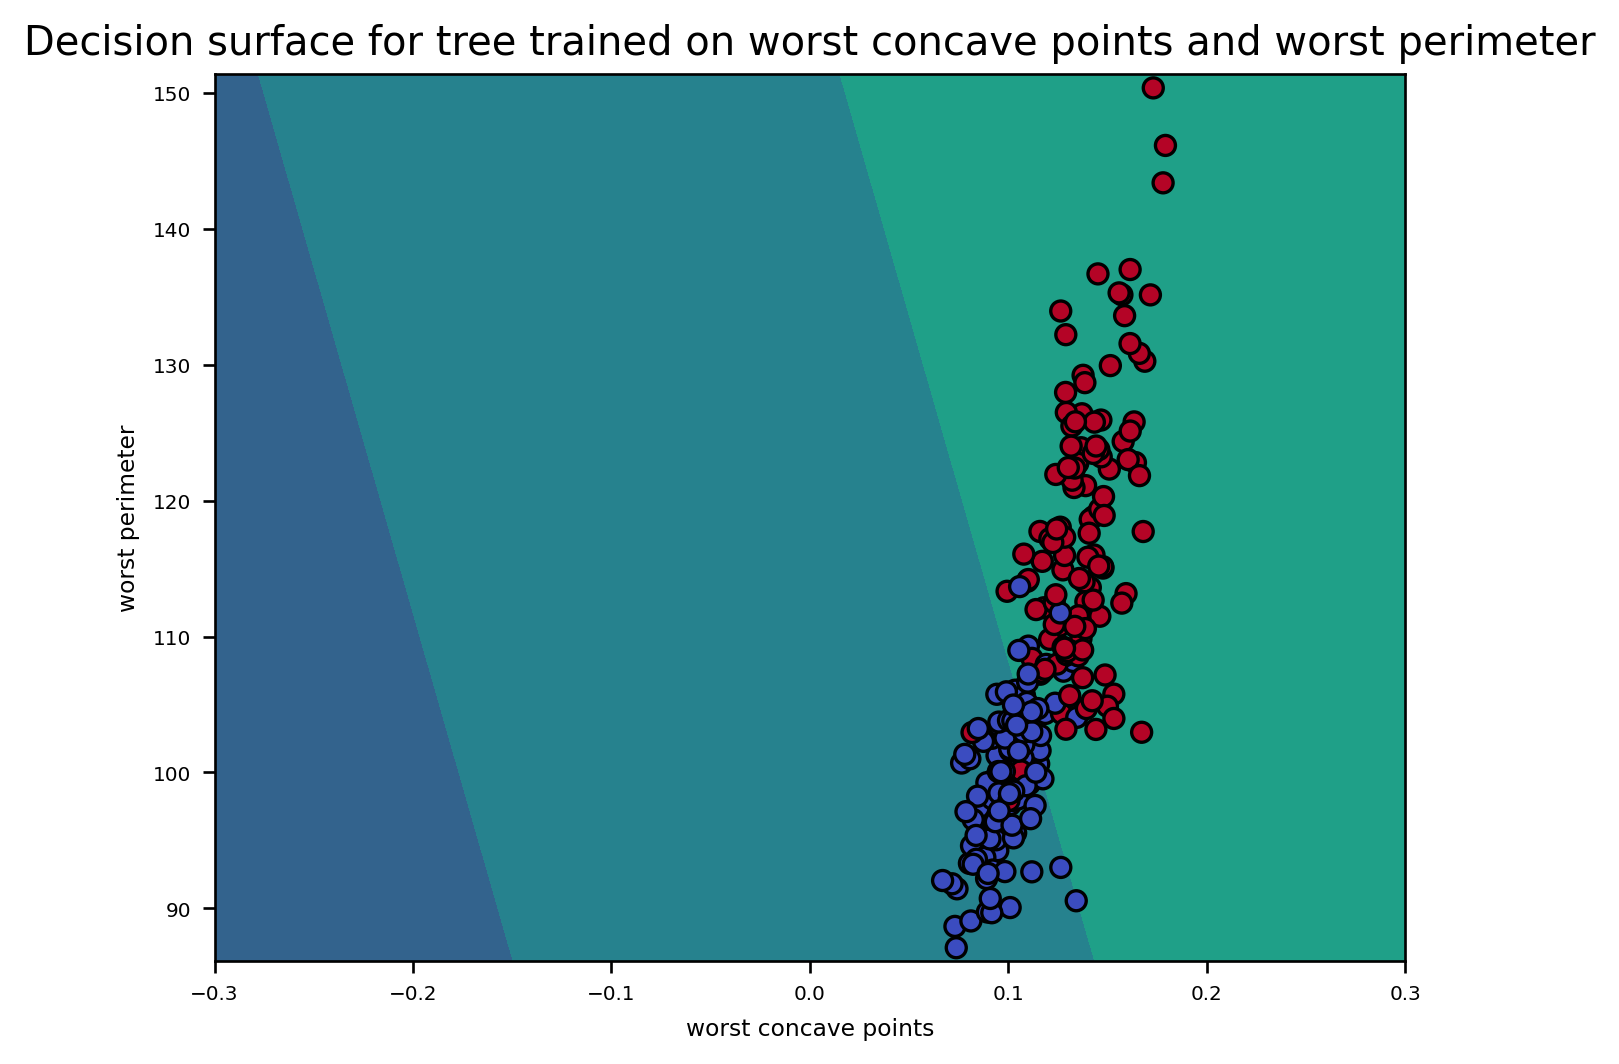

In [88]:
from sklearn.inspection import DecisionBoundaryDisplay

# Assign the name of the best feature obtained in step18 to the variable below. (string)
feature_one = best_four_features[0]

# Assign the name of the second best feature obtained in step18 to the variable below. (string)
feature_two = best_four_features[1]

# Assign the training dataset that you would want to use for this step to the variable below
data2d = X_train_final[[feature_one, feature_two]] 

final_model.fit(data2d, y_train_final)
disp_step19 = DecisionBoundaryDisplay.from_estimator(final_model, data2d)

# Plotting the data points. Use this to create the scatter plot
disp_step19.ax_.scatter(X_train[feature_one], X_train[feature_two],
                        c=y_train, edgecolor="k",
                        cmap=plt.cm.coolwarm)
plt.xlim(-0.3, 0.3)
plt.title(f"Decision surface for tree trained on {feature_one} and {feature_two}")
plt.show()

## Second Round

After presenting our initial results to the client, they come back to us and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

They ask us to **give them a performance estimate for the same problem, but without using any of the "worst" features.**

### Step 20

Let's create a new dataset according to the specifications of the client in round 2. After that, split the data appropriately.

In [92]:
# Assign the data to each variable appropriately
data_r2 = data.drop(columns=worst_group.columns)

X_r2 = data_r2.drop('label', axis=1)
y_r2 = data_r2['label']

X_train_r2, X_test_r2, y_train_r2, y_test_r2 = train_test_split(X_r2, y_r2, test_size=0.2, random_state=42, stratify=y_r2)
X_train_r2, X_val_r2, y_train_r2, y_val_r2 = train_test_split(X_train_r2, y_train_r2, test_size=0.25, random_state=42, stratify=y_train_r2)

# Print the size of each resulting subset
print("Training set size (second round):", len(X_train_r2))
print("Validation set size (second round):", len(X_val_r2))
print("Test set size (second round):", len(X_test_r2))

Training set size (second round): 180
Validation set size (second round): 60
Test set size (second round): 60


### Step 21
Train the best model obtained in the first round on the new dataset and find the best parameters.

In [95]:
from sklearn.metrics import accuracy_score

# Assign the GridSearchCV instance you have obtained in this step to the variable below.
final_model_r2 = GridSearchCV(sgd_pl, param_grid=param_grid_sgd, cv=2, scoring=chosen_metric, verbose=1, return_train_score=True)

# Fit the model to the training data
final_model_r2.fit(X_train_r2, y_train_r2)

# Assign the best parameter dictionary to the variable below.
best_parameters_r2 = final_model_r2.best_params_

# Output best parameters for second round
print(f'best_parameters_r2: {final_model_r2.best_params_}')

# 1. Predict on the validation set
y_pred_val = final_model_r2.predict(X_val_r2)

# 2. Calculate performance metrics
accuracy_val = accuracy_score(y_val_r2, y_pred_val)
recall_val = recall_score(y_val_r2, y_pred_val)
precision_val = precision_score(y_val_r2, y_pred_val)
f1_val = f1_score(y_val_r2, y_pred_val)

print("Validation Metrics")
print("Accuracy: ", accuracy_val)
print("Recall: ", recall_val)
print("Precision: ", precision_val)
print("F1: ", f1_val)

# If the model provides probability estimates of the positive class,
# use them for AUC score calculation; else, use the predictions directly
auc_val = roc_auc_score(y_val_r2, y_pred_val)

print("AUC: ", auc_val)

# The following code is used by the autograder.
step21_data = {
    "final_model_r2": final_model_r2,
    "best_parameters_r2": best_parameters_r2,
    "validation_metrics": {
        "accuracy": accuracy_val,
        "recall": recall_val,
        "precision": precision_val,
        "f1": f1_val,
        "auc": auc_val
    },
    "validation_predictions": y_pred_val
}

Fitting 2 folds for each of 1200 candidates, totalling 2400 fits


C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_mo

best_parameters_r2: {'sgd__alpha': 0.1, 'sgd__eta0': 1, 'sgd__learning_rate': 'adaptive', 'sgd__loss': 'perceptron', 'sgd__penalty': 'elasticnet'}
Validation Metrics
Accuracy:  0.9333333333333333
Recall:  0.896551724137931
Precision:  0.9629629629629629
F1:  0.9285714285714286
AUC:  0.932146829810901


### Step 22
Considering the best parameters identified in the previous step, train your best model using those parameters and calculate and display an unbiased performance measure.

In [97]:
X_train_final_r2, X_test_final_r2, y_train_final_r2, y_test_final_r2 = train_test_split(X_r2, y_r2, test_size=0.09, random_state=42, stratify=y_r2)

# Assign the best model you have trained again in order to get an unbiased performance estimate.
# final_model_r2 = final_model_r2

# Fit the model to the training data
final_model_r2.fit(X_train_final_r2, y_train_final_r2)

# Assign the predictions made from your chosen best model for the unbiased estimate to the variable below.
predictions_final_model_r2 = final_model_r2.predict(X_test_r2)

# Choose a performance metric based on the client's requirement and assign the result to the variable below.
performance_metric_result_r2 = roc_auc_score(y_test_r2, predictions_final_model_r2)

Fitting 2 folds for each of 1200 candidates, totalling 2400 fits


C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\xveen\anaconda3\Lib\site-packages\sklearn\linear_mo

### Step 23
For this step we need to compare the final performance obtained in round 1 with the performance given in round 2. We will use the results from Step 17 and Step 22.

In [101]:
# Final performance for 1st round
final_performance_r1 = chosen_performance_metric_result
print("Final Performance for 1st round:", final_performance_r1)

# Final performance for 2nd round
final_performance_r2 = performance_metric_result_r2
print("Final Performance for 2nd round:", final_performance_r2)

# What is your best model, "r1" or "r2". Put your answer in the variable final_answer (example: final_answer = "r2")
final_answer = "r2" if final_performance_r2 > final_performance_r1 else "r1"
print("Final Answer:", final_answer)

Final Performance for 1st round: 0.9666666666666667
Final Performance for 2nd round: 0.932146829810901
Final Answer: r1


### Step 24

WOOHOO! We have now gone through the rigorous process of testinf and evaluating different models with various parameters and in diverse circumstances, we now have a robust model capable of generalising well to unseen data.

Let's assume that the client has provided data about a new patient in a table format, and is expecting us to make a prediction about the person's condition as soon as possible. The following table contains the information provided by the client:

| Characteristic | Value |
| --- | --- |
| mean radius |13.970546 | 
| mean texture|15.660529 | 
| mean perimeter | 91.432976| 
| mean area |600.575775 | 
| mean smoothness |0.099883 | 
| mean compactness | NaN| 
| mean concavity | 0.07505| 
| mean concave points | 0.023223| 
| mean symmetry | 0.186472| 
| mean fractal dimension | 0.05446|
| radius error | 0.321022 | 
| texture error |1.044633 | 
| perimeter error |2.324773 | 
| area error |31.333479 | 
| smoothness error | 0.005675| 
| compactness error |0.023401 | 
| concavity error |0.026742 | 
| concave points error |0.009808 | 
| symmetry error | 0.029254| 
| fractal dimension error |0.00325 |
| worst radius |12.728135 | 
| worst texture | 23.476671| 
| worst perimeter |103.834522 | 
| worst area | 798.832368| 
| worst smoothness |0.130751 | 
| worst compactness |0.264469 | 
| worst concavity |0.247665 | 
| worst concave points | 0.100153| 
| worst symmetry |0.301228 | 
| worst fractal dimension |0.083051 |  

Our goal is to inform them whether the sample corresponds to a benign or a malignant case. 
We will provide the class and also the probability that the sample belongs to the malignant class.

If our best model corresponds to SGD using loss='perceptron', we can use decision_function instead of predict_proba to obtain the confidence score for our sample instead of the probability of belonging to the malignant class.


In [110]:
# Put your new data in form of a dataframe
new_sample = pd.DataFrame({
    'worst concave points': [0.100153],
    'worst perimeter': [103.834522],
})

# Use the best model to predict. 
model = final_model_r2 if final_answer == "r2" else final_model

# Prediction of the class. You need to say if the sample is bening or malignant ("malignant" or "benign")
prediction_sample = "malignant" if model.predict(new_sample)[0] == 1 else "benign"

# Probability or confidence score of the sample belonging to the malignant class
probability_sample = model.decision_function(new_sample)[0]

# Print your results
print("The class for this sample is ", prediction_sample)

# NOTE: in the case of SGD, Confidence score values will not be bounded within 0 and 1.
print("The probability / confidence score of belonging to malignant class is" , probability_sample)

# The following code is used by the autograder
step24_data = {
    "prediction_sample": prediction_sample,
    "probability_sample": probability_sample
}

The class for this sample is  benign
The probability / confidence score of belonging to malignant class is -0.004399145708702808


#### ✨**Oveena Widyaratne** - University of Adelaide©, B. Compsci Y3 Project 2025✨